In [1]:
import numpy as np
np.set_printoptions(precision=2)
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import ArrayParameter, MultiParameter
from qcodes.instrument.channel import InstrumentChannel, ChannelList
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def print_params(instr):
    for k, v in instr.parameters.items():
        print(k, ': ', v())
        if isinstance(v, ArrayParameter) and v.setpoints is not None:
            print('\t - setpoints: ', v.setpoint_names, v.setpoints)

## Setting up some parameters to be delegates of...

- Make an array parameter that returns an array an (n,) shape array with setpoints

- Make a multi param that returns two values, one a single point and one an array with shape (3,) no setpoints

- Make an instrument channel that has an ArrayParameter and a ManualParameter

- Make an instrument that has a parameter, an array parameter, a multi parameter and two channels

In [3]:
class MyArrayParam(ArrayParameter):
    def __init__(self, name, instrument, start, stop, npts):
        super().__init__(name=name, instrument=instrument, shape=(npts,))
        self.set_up(start, stop, npts)
    
    def set_up(self, start, stop, npts):
        self.setpoints = (tuple(np.linspace(start, stop, npts)), )
        self.setpoint_names = ('array_param_setpoints',)
        self.shape = (npts,)
       
    def get_raw(self):
        return np.random.random(self.shape) * self.setpoints[0]
    
class MyMultiParam(MultiParameter):
    def __init__(self, name, instrument):
        super().__init__(name=name, instrument=instrument, names=('a', 'b'), shapes=((1,), (3,)))
       
    def get_raw(self):
        return np.random.random(), 0.1 * np.arange(3)

class MyInstrumentChannel(InstrumentChannel):
    def __init__(self, parent, name):
        super().__init__(parent=parent, name=name)
        self.add_parameter(name='chan_array_param',
                           parameter_class=MyArrayParam,
                           start=100,
                           stop=5000,
                           npts=4)
        self.add_parameter(name='chan_param',
                           set_cmd=None,
                           initial_value=10)
                       
class MyInstrument(Instrument):
    def __init__(self, name):
        super().__init__(name)
        self.add_parameter(name='param',
                           initial_value=0.5,
                           set_cmd=None)
        self.add_parameter(name='array_param',
                          parameter_class=MyArrayParam,
                          start=0,
                          stop=10,
                          npts=6)
        self.add_parameter(name='multi_param',
                          parameter_class=MyMultiParam)
        instr_chan1 = MyInstrumentChannel(self, 'chan1')
        instr_chan2 = MyInstrumentChannel(self, 'chan2')
        chan_list = ChannelList(self, 'chan_list', MyInstrumentChannel, [instr_chan1, instr_chan2])
        self.add_submodule('chan_list', chan_list)

In [4]:
my_instr = MyInstrument('my_instr')

### Check ArrayParam

Text(0, 0.5, 'array_param')

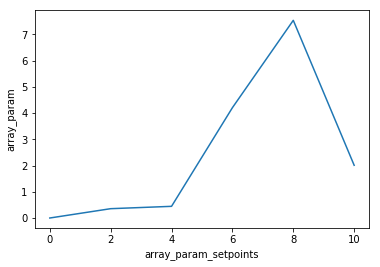

In [5]:
fig = plt.figure()
plt.plot(my_instr.array_param.setpoints[0], my_instr.array_param())
plt.xlabel(my_instr.array_param.setpoint_names[0])
plt.ylabel(my_instr.array_param.name)

### Check Multi Param

In [6]:
print(my_instr.multi_param())
print(my_instr.multi_param.setpoints)

(0.7041774363265063, array([0. , 0.1, 0.2]))
None


### Check Channels

In [7]:
print('chan 1')
print_params(my_instr.chan_list[0])
print('chan 2')
print_params(my_instr.chan_list[1])

chan 1
chan_array_param :  [  52.12  311.27  183.68 1556.38]
	 - setpoints:  ('array_param_setpoints',) ((100.0, 1733.3333333333333, 3366.6666666666665, 5000.0),)
chan_param :  10
chan 2
chan_array_param :  [  98.92 1142.95  314.53  777.73]
	 - setpoints:  ('array_param_setpoints',) ((100.0, 1733.3333333333333, 3366.6666666666665, 5000.0),)
chan_param :  10


/Users/Natalie/Documents/PhD/Qdev/Qcodes/qcodes/instrument/parameter.py:1218: UserWarning: MultiParameters do not support set at this time.
  warnings.warn('MultiParameters do not support set at this time.')


Multi_chan_param 
 ('my_instr_chan1_chan_param', 'my_instr_chan2_chan_param') (10, 10)


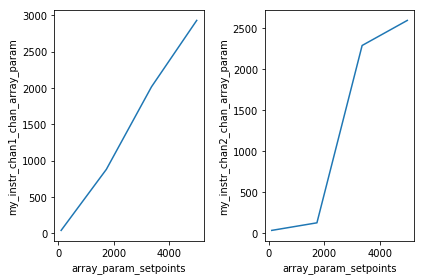

In [8]:
print(my_instr.chan_list.chan_param.name, '\n', my_instr.chan_list.chan_param.names, my_instr.chan_list.chan_param())
fig, axes = plt.subplots(1, 2)
for i, chan_param_val in enumerate(my_instr.chan_list.chan_array_param()):
    axes[i].plot(my_instr.chan_list.chan_array_param.setpoints[i][0], chan_param_val)
    axes[i].set_xlabel(my_instr.chan_list.chan_array_param.setpoint_names[i][0])
    axes[i].set_ylabel(my_instr.chan_list.chan_array_param.full_names[i])
plt.tight_layout()

## Setting up some delegate parameters

In [5]:
from qdev_wrappers.customised_instruments.parameters.delegate_parameters import DelegateParameter, DelegateArrayParameter, DelegateMultiParameter, DelegateMultiChannelParameter

### DelegateParameter

The most intuitive incarnation is when a source parameter is provided and the DelegateParameter merely tracks it. Here I set it up to track the 'param' parameter on my_instr.

In [10]:
delegate_param = DelegateParameter('delegate_parameter',
                                   source=my_instr.param)

In [11]:
my_instr.param(0.5)
delegate_param()
print(my_instr.param._latest)
print(delegate_param._latest)
delegate_param(2.5)
print(my_instr.param._latest)
print(delegate_param._latest)

{'value': 0.5, 'ts': datetime.datetime(2019, 1, 10, 22, 36, 34, 292618), 'raw_value': 0.5}
{'value': 0.5, 'ts': datetime.datetime(2019, 1, 10, 22, 36, 34, 292627), 'raw_value': 0.5}
{'value': 2.5, 'ts': datetime.datetime(2019, 1, 10, 22, 36, 34, 293209), 'raw_value': 2.5}
{'value': 2.5, 'ts': datetime.datetime(2019, 1, 10, 22, 36, 34, 293217), 'raw_value': 2.5}


Getting or setting can be prohibited by means of the kwargs get_fn and set_fn.

In [12]:
delegate_param = DelegateParameter('delegate_parameter',
                                   source=my_instr.param,
                                   set_fn=False,
                                   get_fn=False)
try:
    delegate_param(2)
except RuntimeError as e:
    print(e)

try:
    delegate_param()
except RuntimeError as e:
    print(e)

('Parmeter delegate_parameter not settable', 'setting delegate_parameter to 2')
('Parmeter delegate_parameter not gettable', 'getting delegate_parameter')


If a set_fn is provided it is called before setting the source.

In [13]:
delegate_param = DelegateParameter('delegate_parameter',
                                   source=my_instr.param,
                                   set_fn=lambda x: print(f'setting {my_instr.param.name} to {x}'))

In [14]:
delegate_param(2.5)
print(my_instr.param._latest)
print(delegate_param._latest)

setting param to 2.5
{'value': 2.5, 'ts': datetime.datetime(2019, 1, 10, 22, 36, 35, 338430), 'raw_value': 2.5}
{'value': 2.5, 'ts': datetime.datetime(2019, 1, 10, 22, 36, 35, 338436), 'raw_value': 2.5}


If a source is not provided then the default behaviour is to return a random number on calling get but this can be overwritten by setting the get_fn to True or providing a Callable, the result of which is returned.

In [15]:
delegate_param = DelegateParameter('delegate_parameter')

In [16]:
delegate_param(3)
print(delegate_param._latest)
print(delegate_param())

{'value': 3, 'ts': datetime.datetime(2019, 1, 10, 22, 36, 35, 962599), 'raw_value': 3}
0.0260624755660942


In [17]:
delegate_param = DelegateParameter('delegate_parameter',
                                   get_fn=True)

In [18]:
delegate_param(3)
print(delegate_param._latest)
print(delegate_param())

{'value': 3, 'ts': datetime.datetime(2019, 1, 10, 22, 36, 36, 380614), 'raw_value': 3}
3


In [19]:
delegate_param = DelegateParameter('delegate_parameter',
                                   get_fn=lambda: 100)

In [20]:
delegate_param(3)
print(delegate_param._latest)
print(delegate_param())

{'value': 3, 'ts': datetime.datetime(2019, 1, 10, 22, 36, 36, 778038), 'raw_value': 3}
100


### DelegateArrayParameter

Since ArrayParameters are not settable this one is a bit simpler and there is no set_fn kwarg. If a source is provided then on getting the parameter the metadata is copied (label, unit, setpoints, setpoint_names, setpoint_labels, setpoint_units)

In [21]:
delegate_array_param = DelegateArrayParameter('delegate_array_parameter',
                                              source=my_instr.array_param)

In [22]:
delegate_array_param()
print(delegate_array_param.get_latest())
print(my_instr.array_param.get_latest())
print(delegate_array_param.setpoint_names)
print(my_instr.array_param.setpoint_names)

[0.   0.57 2.52 1.61 3.01 0.91]
[0.   0.57 2.52 1.61 3.01 0.91]
('array_param_setpoints',)
('array_param_setpoints',)


As before getting can be prohibited by setting the get_fn to False

In [23]:
delegate_array_param = DelegateArrayParameter('delegate_array_parameter',
                                              source=my_instr.array_param,
                                              get_fn=False)
try:
    delegate_array_param()
except RuntimeError as e:
    print(e)

('Parmeter delegate_array_parameter not gettable', 'getting delegate_array_parameter')


If no source is provided then the user must take care of setpoints, labels, shape etc and by default a random array of the relevant shape is returned.

In [24]:
delegate_array_param = DelegateArrayParameter('delegate_array_parameter',
                                              shape=(15,))

In [25]:
delegate_array_param()

array([0.53, 0.95, 0.75, 0.78, 0.89, 0.77, 0.12, 0.93, 0.23, 0.34, 0.37,
       0.65, 0.32, 0.9 , 0.78])

A Callable get_fn is available as before (slightly less trivial as it has to match the shape!). It can be provided via the init or set at any time.

In [26]:
delegate_array_param = DelegateArrayParameter('delegate_array_parameter',
                                              shape=(10,),
                                              get_fn=lambda: np.arange(10))
print(delegate_array_param())
delegate_array_param.shape = (5,)
delegate_array_param.get_fn = lambda: np.arange(5)
print(delegate_array_param())

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4]


### DelegateMultiParameter

Similarly the DelegateMultiParameter can interface with a MultiParameter or used to simulate one. Setting is not supported.

In [6]:
delegate_multi_param = DelegateMultiParameter('delegate_multi_parameter',
                                              source=my_instr.multi_param)

In [28]:
delegate_multi_param()
print(delegate_multi_param.get_latest())
print(my_instr.multi_param.get_latest())

(0.5568193080046177, array([0. , 0.1, 0.2]))
(0.5568193080046177, array([0. , 0.1, 0.2]))


Get can be prohibited as before (I won't demo this again, take my word for it). If no source is provided the options agian the choice is between generating random arrays that match the shape or providing a function to generate results:

In [29]:
delegate_multi_param = DelegateMultiParameter('delegate_multi_parameter',
                                              shapes=((15,), (1,)))

In [30]:
delegate_multi_param()

(array([0.56, 0.03, 0.74, 0.27, 0.43, 0.03, 0.53, 0.56, 0.94, 0.72, 0.76,
        0.56, 0.61, 0.49, 0.9 ]), array([0.46]))

In [31]:
delegate_multi_param = DelegateMultiParameter('delegate_multi_parameter',
                                              shapes=((15,), (1,)),
                                              get_fn = lambda: tuple((np.arange(15), np.array([12]))))

In [32]:
delegate_multi_param()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([12]))

### DelegateMultiChannelParameter

A DelegateMultiChannelParameter can be used to track a MultiChannelParameter. If you really wanted to simulate this you should also simulate the underlying channels and their parameters so there is no 'simulation' for this parameter, you have to give it a channelist and paramname which are the equivalent of giving a source to another parameter.  

In [7]:
delegate_multi_chan_param = DelegateMultiChannelParameter('delegate_multi_chan_parameter',
                                                          channellist=my_instr.chan_list,
                                                          paramname='chan_param')

In [12]:
print(delegate_multi_chan_param())
print(my_instr.chan_list.chan_param())

(10, 10)
(10, 10)


For a multi channel array parameter (nb each call generates a new random list so it's still working!).

In [13]:
delegate_multi_chan_param = DelegateMultiChannelParameter('delegate_multi_chan_parameter',
                                                          channellist=my_instr.chan_list,
                                                          paramname='chan_array_param')

In [14]:
print(delegate_multi_chan_param())
print(my_instr.chan_list.chan_array_param())

(array([  77.95, 1147.22, 1490.28, 4363.92]), array([  38.05, 1432.45, 2683.64, 4388.55]))
(array([  18.53,  350.65,  264.58, 2177.58]), array([  78.37, 1476.51, 2877.52, 3198.63]))
